In [1]:
import numpy as np
from pathlib import Path
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from twoStwoR import ppo
from twoStwoR import TwoSTwoR

In [2]:
RUN_NAME = "ppo_twoStwoR_run1_reward_seeds_only"
opath = Path(f"../figures/{RUN_NAME}")
opath.mkdir(parents=True, exist_ok=True)

In [3]:
config = {
    "NUM_STEPS": 128,
    "NUM_ENVS": 16,
    "NUM_ACTORS": 2,
    "TOTAL_TIMESTEPS": 5e6,
    "UPDATE_EPOCHS": 4,
    "NUM_MINIBATCHES": 4,
    "GAMMA": 0.99,
    "GAE_LAMBDA": 0.95,
    "VF_COEF": 0.5,
    "ENT_COEF": 0.01,
    "CLIP_EPS": 0.2,
    "SEED": 42,
    "ACTIVATION": "tanh",
    "LR": 2.5e-4,
    "GRID_SIZE": 10,
}

In [4]:
train_fn = ppo.make_train(config)
rng = jax.random.PRNGKey(config["SEED"])
out = train_fn(rng)
train_state, env_state, obs, rng = out['runner_state']
tree_traj, fungus_traj, metric = out['info']

In [5]:
def extract_episodes(qoi_traj: jnp.ndarray, done_traj: jnp.ndarray):
    """
    Extracts complete and incomplete episodes from batched trajectory data.

    Args:
        qoi_traj: JAX array of quantity of interest (QOI) with shape (NUM_UPDATES, NUM_STEPS, NUM_ENVS).
        done_traj: JAX array of done flags with shape (NUM_UPDATES, NUM_STEPS, NUM_ENVS).

    Returns:
        A list of lists, where each inner list contains numpy arrays of QOIs for
        episodes from a single environment.
    """
    num_updates, num_steps, num_envs = qoi_traj.shape
    total_steps = num_updates * num_steps

    # Flatten and convert to numpy for efficient, non-JIT analysis
    qoi_np = np.array(qoi_traj.reshape(total_steps, num_envs))
    done_np = np.array(done_traj.reshape(total_steps, num_envs))

    episode_qoi_per_env = [[] for _ in range(num_envs)]

    # Find the indices of done flags for each environment
    for env_idx in range(num_envs):
        done_indices_env = np.where(done_np[:, env_idx])[0]

        last_done_step = -1
        # Extract rewards for completed episodes
        for done_step_idx in done_indices_env:

            start_step = last_done_step + 1
            episode_qoi = qoi_np[start_step : done_step_idx + 1, env_idx]
            if episode_qoi.size > 0:
                episode_qoi_per_env[env_idx].append(episode_qoi)
            last_done_step = done_step_idx

        # Handle the final, incomplete episode
        if last_done_step + 1 < total_steps:
            remaining_qoi = qoi_np[last_done_step + 1:, env_idx]
            if remaining_qoi.size > 0:
                episode_qoi_per_env[env_idx].append(remaining_qoi)

    max_episode_number = max(len(episodes) for episodes in episode_qoi_per_env)
    max_episode_length = max(len(episode) for env_episodes in episode_qoi_per_env for episode in env_episodes)
    qoi_arr = np.zeros((num_envs, max_episode_number, max_episode_length))

    for env_idx, env_episodes in enumerate(episode_qoi_per_env):
        for episode_idx, episode in enumerate(env_episodes):
                qoi_arr[env_idx, episode_idx, :len(episode)] = episode
                if len(episode) < max_episode_length:
                    qoi_arr[env_idx, episode_idx, len(episode):] = np.nan

    return qoi_arr

In [6]:
tree_state, tree_info = tree_traj.info
fungus_state, fungus_info = fungus_traj.info

In [7]:
tree_rewards_episodes = extract_episodes(tree_traj.reward, tree_traj.done)
fungus_rewards_episodes = extract_episodes(fungus_traj.reward, fungus_traj.done)

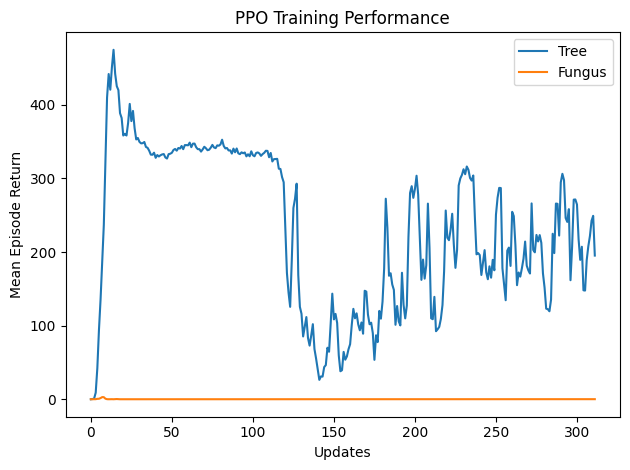

In [8]:
plt.plot(tree_rewards_episodes.sum(axis=-1).mean(axis=0), label='Tree')
plt.plot(fungus_rewards_episodes.sum(axis=-1).mean(axis=0), label='Fungus')
plt.xlabel('Updates')
plt.ylabel('Mean Episode Return')
plt.title('PPO Training Performance')
plt.legend()
plt.tight_layout()

plt.savefig(opath / f"episode_return_per_update_{RUN_NAME}.png", bbox_inches='tight', dpi=300)
plt.show()

In [9]:
tree_biomass_episodes = extract_episodes(tree_state.biomass, tree_traj.done)
tree_seeds_episodes = extract_episodes(tree_info['seeds_generated'], tree_traj.done)
tree_growth_episodes = extract_episodes(tree_info['growth'], tree_traj.done)
tree_defence_episodes = extract_episodes(tree_info['defence'], tree_traj.done)
tree_health_episodes = extract_episodes(tree_state.health, tree_traj.done)
tree_s_trade_episodes = extract_episodes(tree_info['s_trade'], tree_traj.done)
tree_p_trade_episodes = extract_episodes(tree_info['p_trade'], tree_traj.done)
tree_s_used_episodes = extract_episodes(tree_info['sugars_used'], tree_traj.done)
tree_p_used_episodes = extract_episodes(tree_info['phosphorus_used'], tree_traj.done)
tree_s_gen_episodes = extract_episodes(tree_info['sugars_generated'], tree_traj.done)

fungus_biomass_episodes = extract_episodes(fungus_state.biomass, fungus_traj.done)
fungus_seeds_episodes = extract_episodes(fungus_info['seeds_generated'], fungus_traj.done)
fungus_growth_episodes = extract_episodes(fungus_info['growth'], fungus_traj.done)
fungus_defence_episodes = extract_episodes(fungus_info['defence'], fungus_traj.done)
fungus_health_episodes = extract_episodes(fungus_state.health, fungus_traj.done)
fungus_s_trade_episodes = extract_episodes(fungus_info['s_trade'], fungus_traj.done)
fungus_p_trade_episodes = extract_episodes(fungus_info['p_trade'], fungus_traj.done)
fungus_s_used_episodes = extract_episodes(fungus_info['sugars_used'], fungus_traj.done)
fungus_p_used_episodes = extract_episodes(fungus_info['phosphorus_used'], fungus_traj.done)

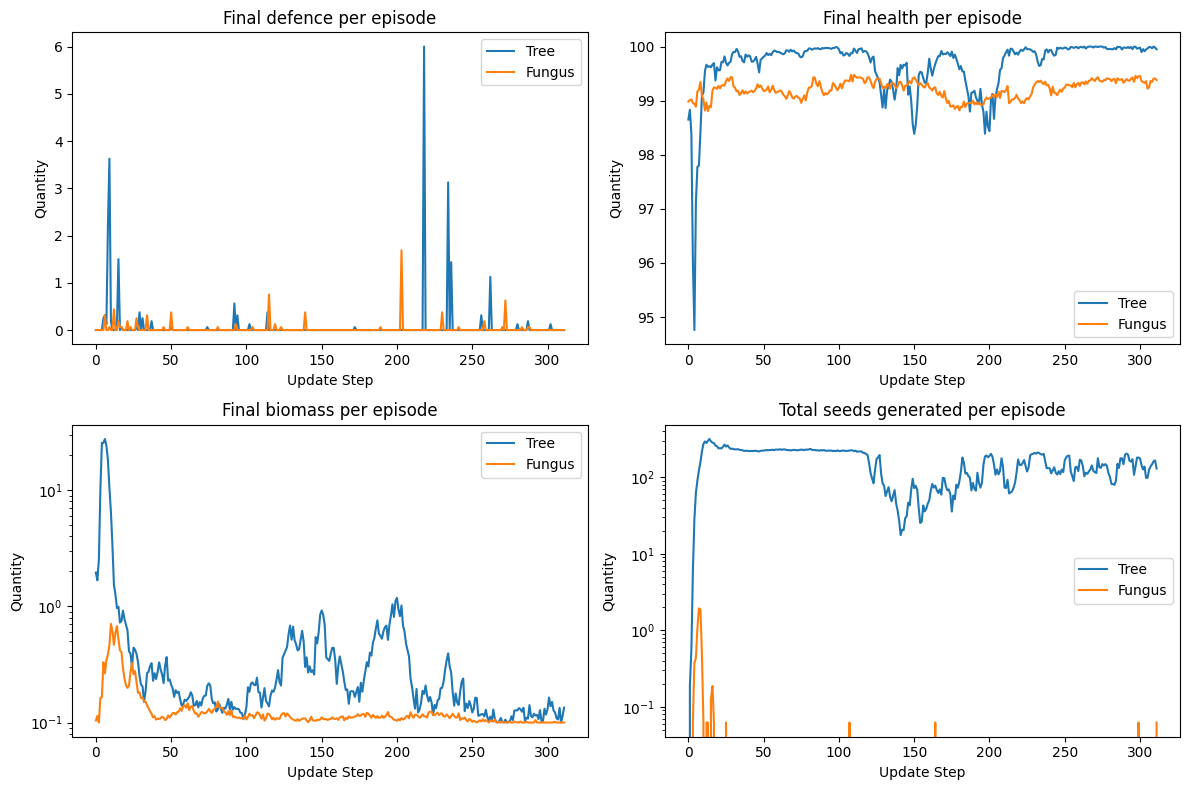

In [10]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0, 0].plot(tree_defence_episodes.mean(axis=0)[:, -2])
axs[0, 0].plot(fungus_defence_episodes.mean(axis=0)[:, -2])
axs[0, 0].set_title('Final defence per episode')

axs[0, 1].plot(tree_health_episodes.mean(axis=0)[:, -2])
axs[0, 1].plot(fungus_health_episodes.mean(axis=0)[:, -2])
axs[0, 1].set_title('Final health per episode')

axs[1, 0].plot(tree_biomass_episodes.mean(axis=0)[:, -2])
axs[1, 0].plot(fungus_biomass_episodes.mean(axis=0)[:, -2])
axs[1, 0].set_yscale('log')
axs[1, 0].set_title('Final biomass per episode')

axs[1, 1].plot(tree_seeds_episodes.sum(axis=-1).mean(axis=0))
axs[1, 1].plot(fungus_seeds_episodes.sum(axis=-1).mean(axis=0))
axs[1, 1].set_yscale('log')
axs[1, 1].set_title('Total seeds generated per episode')

for ax in axs.flat:
    ax.set_xlabel('Update Step')
    ax.set_ylabel('Quantity')
    ax.legend(['Tree', 'Fungus'])

plt.tight_layout()
plt.savefig(opath / f"dhbs_per_update_step_{RUN_NAME}.png", bbox_inches='tight', dpi=300)
plt.show()

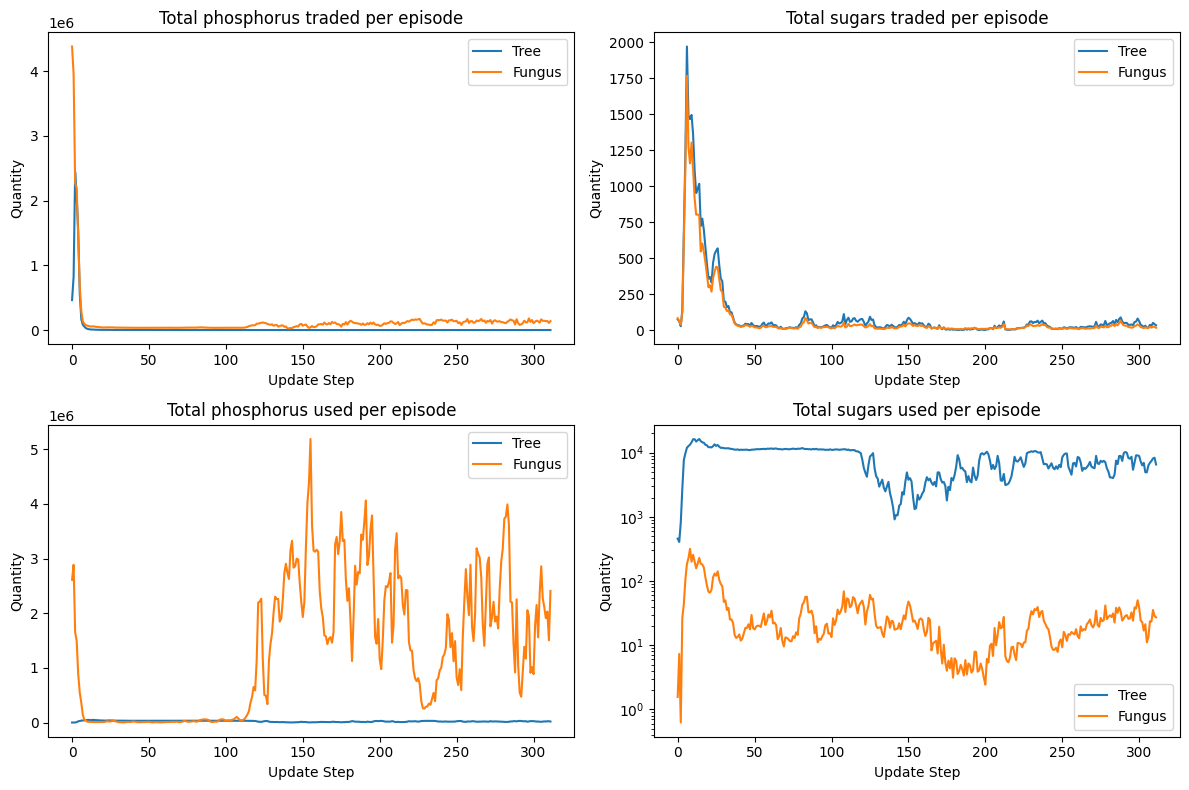

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs[0, 0].plot(tree_p_trade_episodes.sum(axis=-1).mean(axis=0))
axs[0, 0].plot(fungus_p_trade_episodes.sum(axis=-1).mean(axis=0))
axs[0, 0].set_title('Total phosphorus traded per episode')

axs[0, 1].plot(tree_s_trade_episodes.sum(axis=-1).mean(axis=0))
axs[0, 1].plot(fungus_s_trade_episodes.sum(axis=-1).mean(axis=0))
axs[0, 1].set_title('Total sugars traded per episode')

axs[1, 0].plot(tree_p_used_episodes.sum(axis=-1).mean(axis=0))
axs[1, 0].plot(fungus_p_used_episodes.sum(axis=-1).mean(axis=0))
axs[1, 0].set_title('Total phosphorus used per episode')

axs[1, 1].plot(tree_s_used_episodes.sum(axis=-1).mean(axis=0))
axs[1, 1].plot(fungus_s_used_episodes.sum(axis=-1).mean(axis=0))
axs[1, 1].set_yscale('log')
axs[1, 1].set_title('Total sugars used per episode')

for ax in axs.flat:
    ax.set_xlabel('Update Step')
    ax.set_ylabel('Quantity')
    ax.legend(['Tree', 'Fungus'])

plt.tight_layout()
plt.savefig(opath / f"ps_trade_usage_per_update_step_{RUN_NAME}.png", bbox_inches='tight', dpi=300)
plt.show()

# Evaluation trajectory
Use final policy networks to collect a evaluation trajectory.

In [12]:
def collect_eval_traj(rng, train_state):
    max_episode_steps = 1000
    env = TwoSTwoR(grid_size=config["GRID_SIZE"], max_episode_steps=max_episode_steps)
    first_obs, env_state = env.reset(rng)

    def env_step(runner_state, x):
        train_state, env_state, last_obs, rng = runner_state
        rng, tree_act_rng, fungus_act_rng = jax.random.split(rng, 3)

        obs_batch = ppo.batchify(last_obs, env.agents, 1, config["NUM_ACTORS"])
        tree_pi, _ = train_state['tree'].apply_fn(train_state["tree"].params, obs_batch[0])
        fungus_pi, _ = train_state['fungus'].apply_fn(train_state["fungus"].params, obs_batch[1])
    
        tree_action = tree_pi.sample(seed=tree_act_rng)
        fungus_action = fungus_pi.sample(seed=fungus_act_rng)

        env_act = ppo.unbatchify(
            jnp.stack([tree_action, fungus_action]),
            env.agents, 1, config["NUM_ACTORS"]
        )
        env_act = jax.tree.map(lambda x: jnp.squeeze(x, axis=0), env_act)

        rng, rng_step = jax.random.split(rng)
        obs, env_state, reward, done, info = env.step_env(rng_step, env_state, env_act)

        runner_state = (train_state, env_state, obs, rng)
        return runner_state, (env_state, done, info['shaped_reward'])

    runner_state = (train_state, env_state, first_obs, rng)
    runner_state, (env_state, done, info) = jax.lax.scan(
        env_step, runner_state, None, max_episode_steps
    )
    return env_state, done, info

def last_complete_episode(episodes: jnp.ndarray) -> jnp.ndarray:
    """
    Returns the last complete episode from a 3D array of shape (NUM_EPISODES, EPISODE_LENGTH).
    If no complete episode exists, returns an empty array.
    Expects episodes to be the mean of NUM_ENVS.
    """
    complete_episodes = episodes[~jnp.isnan(episodes).any(axis=-1)]
    if complete_episodes.size == 0:
        return jnp.array([])  # Return empty array if no complete episodes
    return complete_episodes[-1] # Return the last complete episode

def constrain_actions(actions: np.ndarray) -> np.ndarray:
    actions = actions / np.sum(actions, axis=0, keepdims=True)
    return actions

In [13]:
env_state, done, info = collect_eval_traj(rng, train_state)

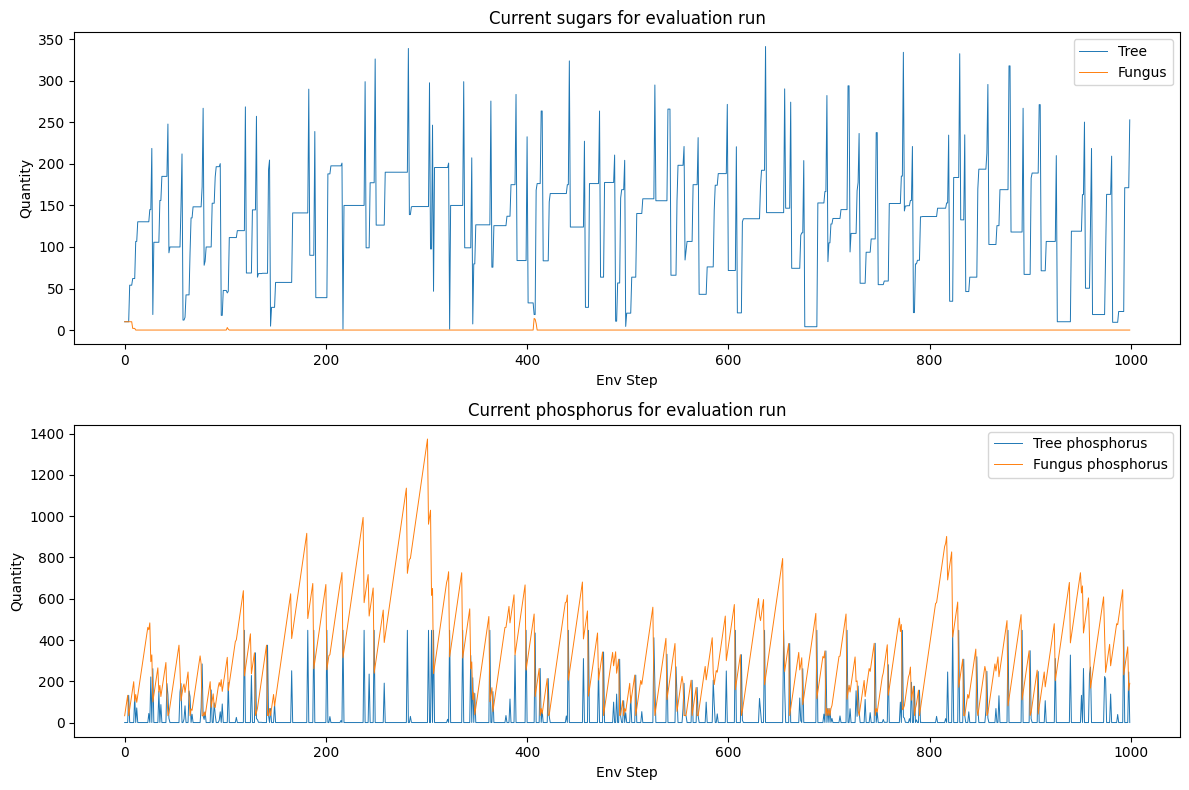

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8))
axs[0].plot(env_state.tree_agent.sugars, label='Tree', linewidth=0.7)
axs[0].plot(env_state.fungus_agent.sugars, label='Fungus', linewidth=0.7)
axs[0].set_title('Current sugars for evaluation run')

axs[1].plot(env_state.tree_agent.phosphorus, label='Tree phosphorus', linewidth=0.7)
axs[1].plot(env_state.fungus_agent.phosphorus, label='Fungus phosphorus', linewidth=0.7)
axs[1].set_title('Current phosphorus for evaluation run')

for ax in axs.flat:
    ax.set_xlabel('Env Step')
    ax.set_ylabel('Quantity')
    ax.legend()

plt.tight_layout()

plt.savefig(opath / f"eval_episode_sugars_phosphorus_{RUN_NAME}.png", bbox_inches='tight', dpi=300)
plt.show()

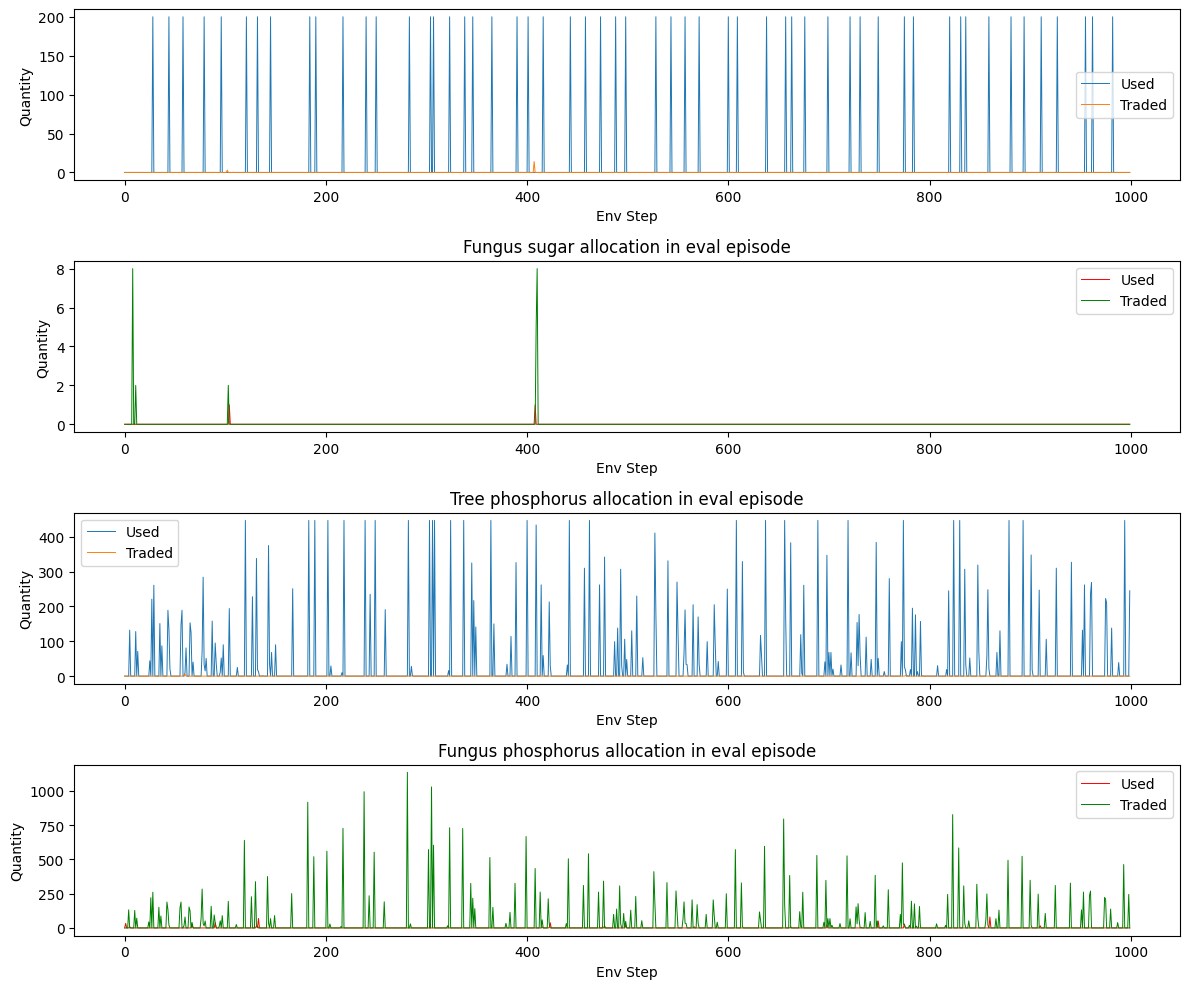

In [15]:
fig, axs = plt.subplots(4, 1, figsize=(12, 10))

axs[0].plot(info['tree']['sugars_used'], label='Used', linewidth=0.7)
axs[0].plot(info['tree']['s_trade'], label='Traded', linewidth=0.7)
axs[1].set_title('Tree sugar allocation in eval episode')

axs[1].plot(info['fungus']['sugars_used'], label='Used', linewidth=0.7, c='r')
axs[1].plot(info['fungus']['s_trade'], label='Traded', linewidth=0.7, c='g')
axs[1].set_title('Fungus sugar allocation in eval episode')

axs[2].plot(info['tree']['phosphorus_used'], label='Used', linewidth=0.7)
axs[2].plot(info['tree']['p_trade'], label='Traded', linewidth=0.7)
axs[2].set_title('Tree phosphorus allocation in eval episode')

axs[3].plot(info['fungus']['phosphorus_used'], label='Used', linewidth=0.7, c='r')
axs[3].plot(info['fungus']['p_trade'], label='Traded', linewidth=0.7, c='g')
axs[3].set_title('Fungus phosphorus allocation in eval episode')

for ax in axs.flat:
    ax.set_xlabel('Env Step')
    ax.set_ylabel('Quantity')
    ax.legend()

plt.tight_layout()
plt.savefig(opath / f"eval_episode_sugars_phosphorus_usage_{RUN_NAME}.png", bbox_inches='tight', dpi=300)
plt.show()

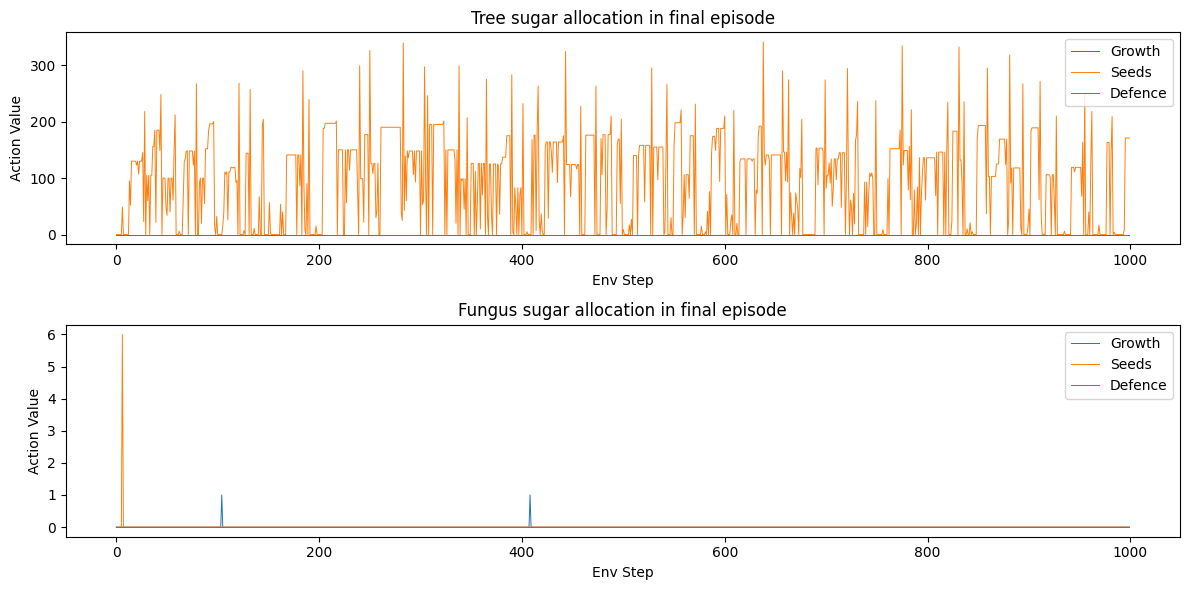

In [16]:
fig, axs = plt.subplots(2, 1, figsize=(12, 6))

axs[0].plot(info['tree']['growth'], label='Growth', linewidth=0.7)
axs[0].plot(info['tree']['reproduction'], label='Seeds', linewidth=0.7)
axs[0].plot(info['tree']['defence'], label='Defence', linewidth=0.7)
axs[0].set_title('Tree sugar allocation in final episode')

axs[1].plot(info['fungus']['growth'], label='Growth', linewidth=0.7)
axs[1].plot(info['fungus']['reproduction'], label='Seeds', linewidth=0.7)
axs[1].plot(info['fungus']['defence'], label='Defence', linewidth=0.7)
axs[1].set_title('Fungus sugar allocation in final episode')

for ax in axs.flat:
    ax.set_xlabel('Env Step')
    ax.set_ylabel('Action Value')
    ax.legend()

plt.tight_layout()

plt.savefig(opath / f"eval_episode_sugar_allocation_{RUN_NAME}.png", bbox_inches='tight', dpi=300)
plt.show()

In [17]:
tree_s_actions = np.stack([info['tree']['sugars_used'], info['tree']['s_trade']])
tree_s_actions_constrained = np.where(np.sum(tree_s_actions, axis=0) > 1.0, constrain_actions(tree_s_actions), tree_s_actions)
fungus_s_actions = np.stack([info['fungus']['sugars_used'], info['fungus']['s_trade']])
fungus_s_actions_constrained = np.where(np.sum(fungus_s_actions, axis=0) > 1.0, constrain_actions(fungus_s_actions), fungus_s_actions)

tree_p_actions = np.stack([info['tree']['phosphorus_used'], info['tree']['p_trade']])
tree_p_actions_constrained = np.where(np.sum(tree_p_actions, axis=0) > 1.0, constrain_actions(tree_p_actions), tree_p_actions)
fungus_p_actions = np.stack([info['fungus']['phosphorus_used'], info['fungus']['p_trade']])
fungus_p_actions_constrained = np.where(np.sum(fungus_p_actions, axis=0) > 1.0, constrain_actions(fungus_p_actions), fungus_p_actions)

/var/folders/g5/h0yjdszs0pz_qr3k5z8bjjq80000gp/T/ipykernel_17168/603883952.py:47: RuntimeWarning: invalid value encountered in divide
  actions = actions / np.sum(actions, axis=0, keepdims=True)


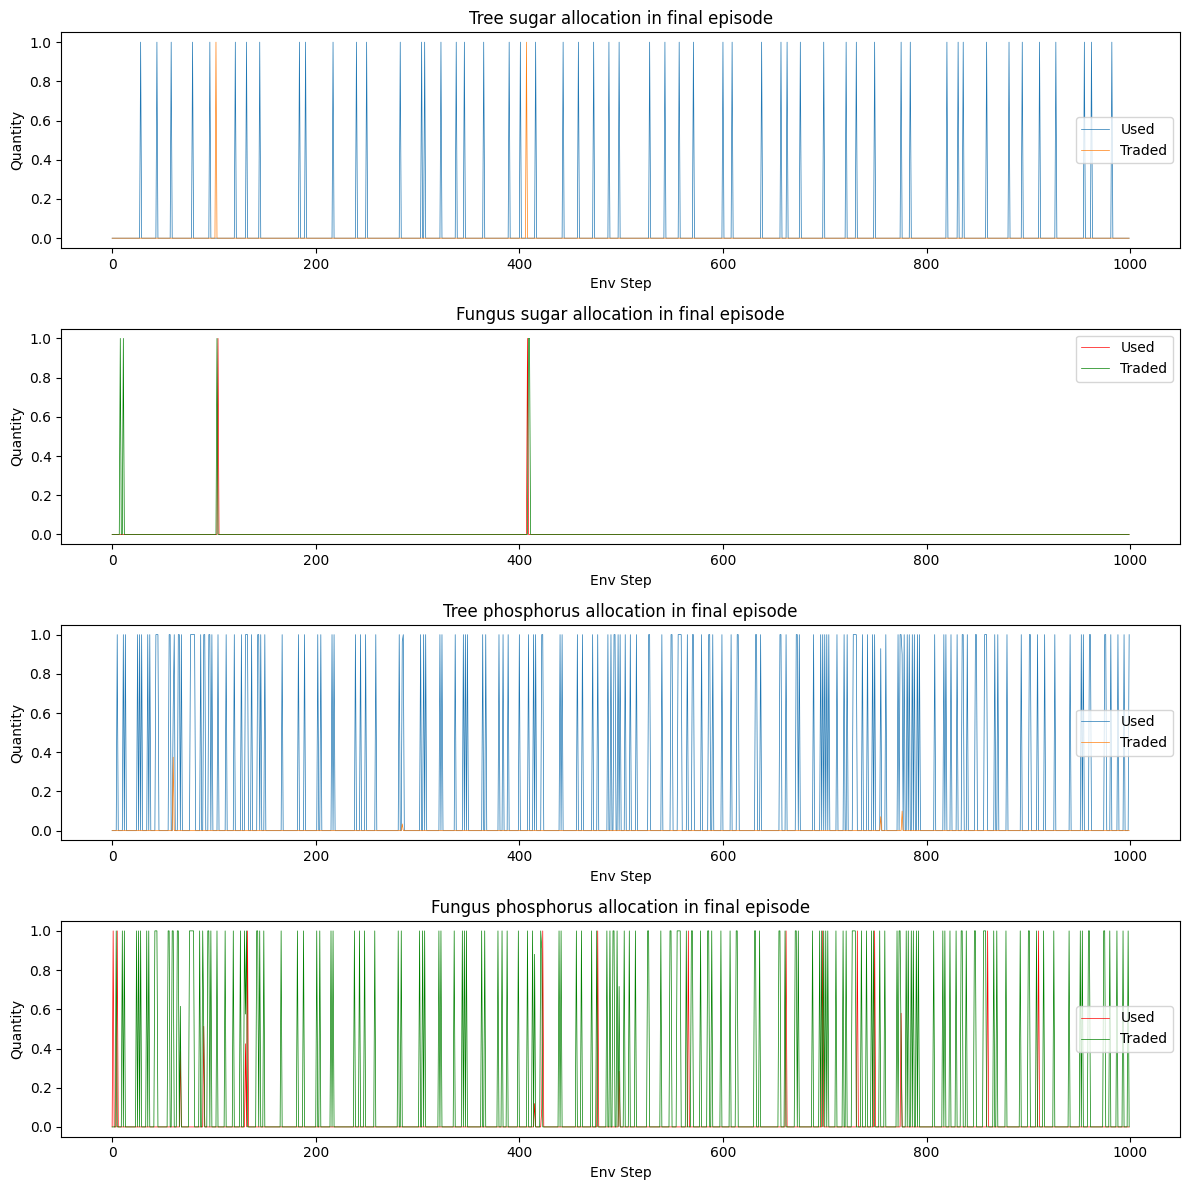

In [18]:
fig, axs = plt.subplots(4, 1, figsize=(12, 12))

axs[0].plot(tree_s_actions_constrained[0], label='Used', linewidth=0.5)
axs[0].plot(tree_s_actions_constrained[1], label='Traded', linewidth=0.5)
axs[0].set_title('Tree sugar allocation in final episode')
axs[1].plot(fungus_s_actions_constrained[0], label='Used', linewidth=0.5, c='r')
axs[1].plot(fungus_s_actions_constrained[1], label='Traded', linewidth=0.5, c='g')
axs[1].set_title('Fungus sugar allocation in final episode')

axs[2].plot(tree_p_actions_constrained[0], label='Used', linewidth=0.5)
axs[2].plot(tree_p_actions_constrained[1], label='Traded', linewidth=0.5)
axs[2].set_title('Tree phosphorus allocation in final episode')
axs[3].plot(fungus_p_actions_constrained[0], label='Used', linewidth=0.5, c='r')
axs[3].plot(fungus_p_actions_constrained[1], label='Traded', linewidth=0.5, c='g')
axs[3].set_title('Fungus phosphorus allocation in final episode')

for ax in axs.flat:
    ax.set_xlabel('Env Step')
    ax.set_ylabel('Quantity')
    ax.legend()

plt.tight_layout()
plt.savefig(opath / f"eval_episode_sugars_phosphorus_usage_constrained_{RUN_NAME}.png", bbox_inches='tight', dpi=300)
plt.show()

In [19]:
tree_sused_actions = np.stack([info['tree']['growth'], info['tree']['defence'], info['tree']['reproduction']])
tree_sused_actions_constrained = np.where(np.sum(tree_sused_actions, axis=0) > 1.0, constrain_actions(tree_sused_actions), tree_sused_actions)

fungus_sused_actions = np.stack([info['fungus']['growth'], info['fungus']['defence'], info['fungus']['reproduction']])
fungus_sused_actions_constrained = np.where(np.sum(fungus_sused_actions, axis=0) > 1.0, constrain_actions(fungus_sused_actions), fungus_sused_actions)

/var/folders/g5/h0yjdszs0pz_qr3k5z8bjjq80000gp/T/ipykernel_69222/603883952.py:47: RuntimeWarning: invalid value encountered in divide
  actions = actions / np.sum(actions, axis=0, keepdims=True)


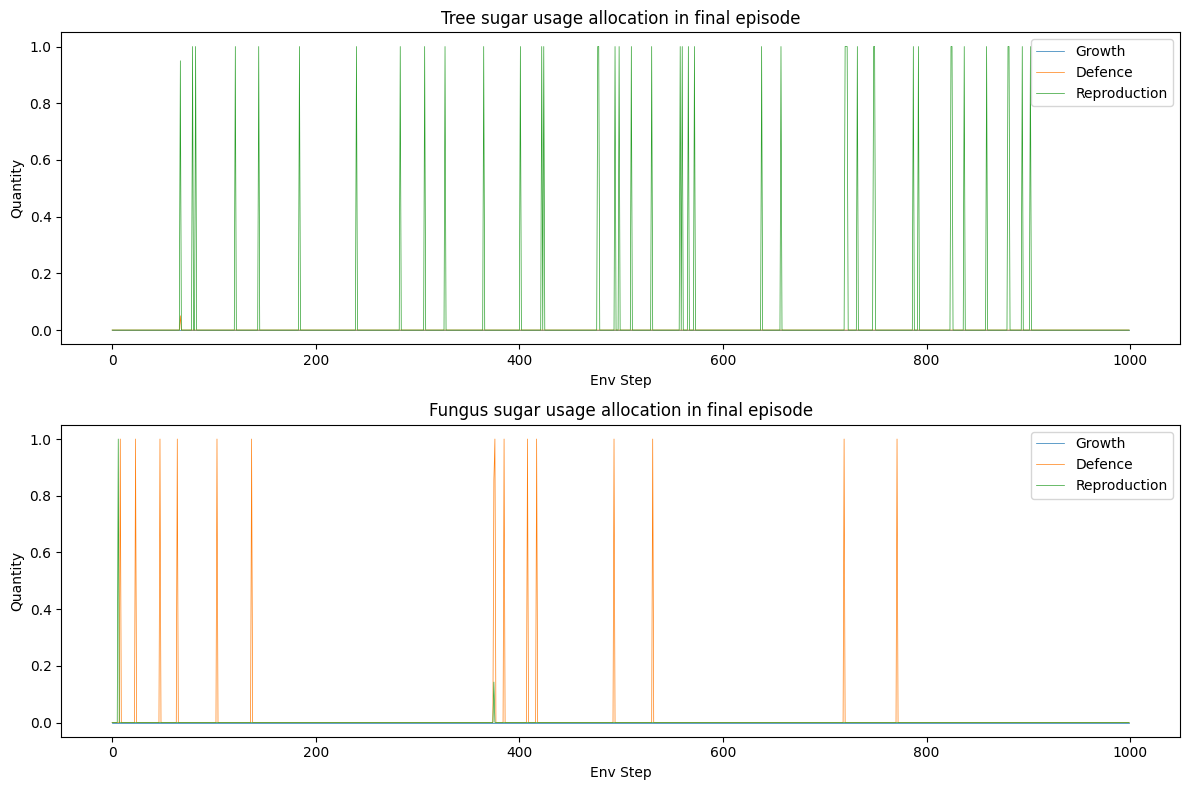

In [20]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8))

axs[0].plot(tree_sused_actions_constrained[0], label='Growth', linewidth=0.5)
axs[0].plot(tree_sused_actions_constrained[1], label='Defence', linewidth=0.5)
axs[0].plot(tree_sused_actions_constrained[2], label='Reproduction', linewidth=0.5)
axs[0].set_title('Tree sugar usage allocation in final episode')
axs[1].plot(fungus_sused_actions_constrained[0], label='Growth', linewidth=0.5)
axs[1].plot(fungus_sused_actions_constrained[1], label='Defence', linewidth=0.5)
axs[1].plot(fungus_sused_actions_constrained[2], label='Reproduction', linewidth=0.5)
axs[1].set_title('Fungus sugar usage allocation in final episode')

for ax in axs.flat:
    ax.set_xlabel('Env Step')
    ax.set_ylabel('Quantity')
    ax.legend()

plt.tight_layout()
plt.savefig(opath / f"eval_episode_sugar_allocation_constrained_{RUN_NAME}.png", bbox_inches='tight', dpi=300)
plt.show()

# Train with multiple seeds to inspect impact of weights initialisation

In [3]:
config["NUM_SEEDS"] = 5

In [4]:
train_fn = ppo.make_train(config)
rng = jax.random.PRNGKey(config["SEED"])
rngs = jax.random.split(rng, config["NUM_SEEDS"])

with jax.disable_jit(False):
    train_jit = jax.jit(jax.vmap(train_fn))
    out = train_jit(rngs)

In [5]:
train_state, env_state, obs, rng = out['runner_state']
tree_traj, fungus_traj, metric = out['info']

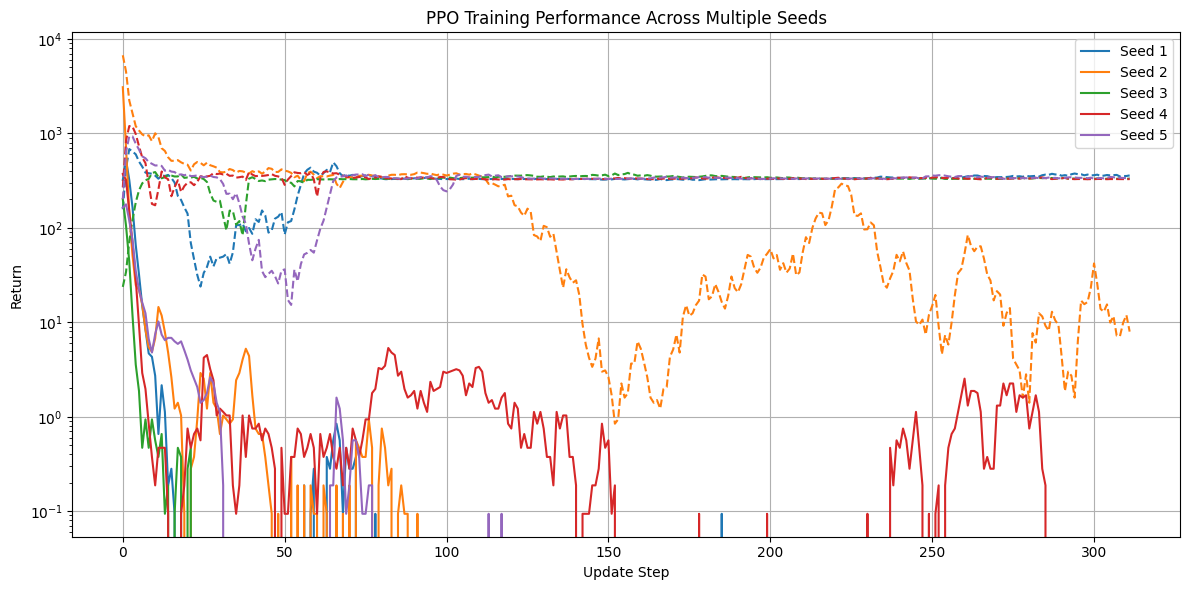

In [ ]:
colours = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

plt.figure(figsize=(12, 6))
plt.title('PPO Training Performance Across Multiple Seeds')
plt.grid(True)
for i in range(config["NUM_SEEDS"]):
    tree_rewards_episodes = extract_episodes(tree_traj.reward[i], tree_traj.done[i])
    fungus_rewards_episodes = extract_episodes(fungus_traj.reward[i], fungus_traj.done[i])

    plt.plot(tree_rewards_episodes.sum(axis=-1).mean(axis=0), linestyle='--', c=colours[i])
    plt.plot(fungus_rewards_episodes.sum(axis=-1).mean(axis=0), label=f'Seed {i+1}', c=colours[i])
    plt.xlabel('Updates')
    plt.ylabel('Mean Episode Return')
    plt.legend()

plt.xlabel("Update Step")
plt.ylabel("Return (log)")
plt.yscale('log')
plt.tight_layout()
plt.savefig(opath / f"episode_return_per_update_multiple_seeds_{RUN_NAME}.png", bbox_inches='tight', dpi=300)
plt.show()